## Import Libraries

In [820]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dagshub
import mlflow


## Connect to my Remote Repository on dagshub

In [821]:

dagshub.init(repo_owner='CarlTeapot', repo_name='ML_assignment1', mlflow=True)


Initialized MLflow to track repo "CarlTeapot/ML_assignment1"

Repository CarlTeapot/ML_assignment1 initialized!

In [822]:
path = "./mlData"
df = pd.read_csv(path + "/train.csv")

Extract SalePrice as a Y vector 

In [823]:
y_train = df['SalePrice']

Find the Parameters with the most null values

In [824]:
total = df.isnull().sum().sort_values(ascending=False)
percent = ((df.isnull().sum()/df.isnull().count()) * 100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
MasVnrType,872,59.726027
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageQual,81,5.547945
GarageFinish,81,5.547945
GarageType,81,5.547945


Even though some of the parameters on the top of this list might seem important, like the Pool quality or a fireplace quality, it would be safe to ignore them considering just how much of the houses dont have either of them. and looking at their correlation with price, we can safely assume that they are not important

In [825]:
rem_missing_data=missing_data[missing_data['Percent'] < 20]

df = df.drop(missing_data[missing_data['Percent'] > 20].index,axis=1)


We still have 13 parameters that contain null values left in our data. now we have to figure out which approach is best:
1) Dropping these columns entirely?
2) replacing the null values with modes or medianes

In [826]:
rem_missing_data[rem_missing_data['Percent'] > 0].shape

(13, 2)

## lets check the LotFrontage parameter.

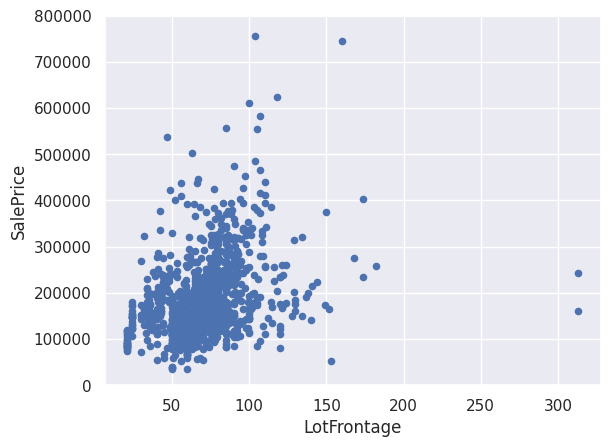

In [827]:
var = 'LotFrontage'
data = pd.concat([df['SalePrice'], df[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

As we can see, it has a very random relationship with a SalePrice parameter, so it would be safe to ignore it.  Same can be said with the MasVnrArea and GarageYrBlt parameters. We can also safely assume that the only garage parameters that might affect our predictions might be Garage Quality and Garage Condition

In [828]:
df = df.drop(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], axis=1)


In [829]:
rem_missing_data = rem_missing_data.drop(['LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'GarageFinish', 'GarageType'])
rem_missing_data = rem_missing_data[rem_missing_data['Percent'] > 0]

We shouldnt drop "Electrical" parameter because of 1 Null value. so lets just delete the row with the null electricity variable
(who would want to buy a house without an electricity system anyway)

In [830]:
df = df.drop(df.loc[df['Electrical'].isnull()].index)
rem_missing_data.drop('Electrical', inplace=True)


In [831]:
rem_missing_data

,Total,Percent
GarageQual,81,5.547945
GarageCond,81,5.547945
BsmtFinType2,38,2.602740
BsmtExposure,38,2.602740
BsmtCond,37,2.534247
BsmtQual,37,2.534247
BsmtFinType1,37,2.534247


Lets get rid of nulls in the Garage and Basement parameters, convert them into numericals and combine them into two parameters

In [832]:
garage_cols = ['GarageQual', 'GarageCond']
qual_map = {
    'Ex': 5,   # Excellent
    'Gd': 4,   # Good
    'TA': 3,   # Typical/Average
    'Fa': 2,   # Fair
    'Po': 1,   # Poor
    np.nan: 0  # No garage
}

for col in ['GarageQual', 'GarageCond']:
    df[col] = df[col].map(qual_map)

As we can see, after converting Garage Quality parameter to a numerical one, it doesnt really have a linear relationship with SalePrice, but it has some kind of relationship, because, as we can see, houses without garages or houses with poor ones arent as expensive, so lets keep these variables.

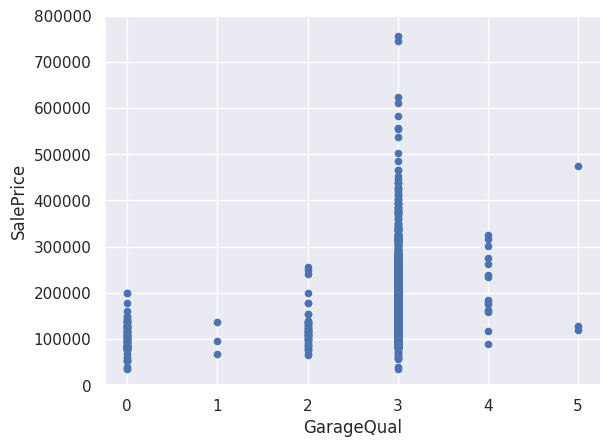

In [833]:
var = 'GarageQual'
data = pd.concat([df['SalePrice'], df[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

Garage Quality and Garage condition are kind of the same variables, so lets drop one of them

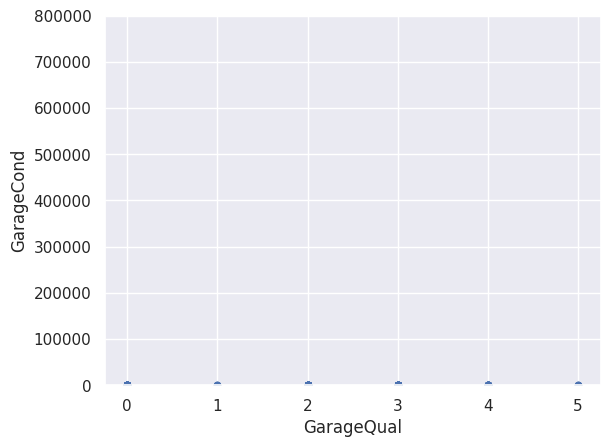

In [834]:
var = 'GarageQual'
data = pd.concat([df['GarageCond'], df[var]], axis=1)
data.plot.scatter(x=var, y='GarageCond', ylim=(0,800000));

In [835]:
df.drop('GarageCond', axis=1, inplace=True)

In [836]:
rem_missing_data

,Total,Percent
GarageQual,81,5.547945
GarageCond,81,5.547945
BsmtFinType2,38,2.602740
BsmtExposure,38,2.602740
BsmtCond,37,2.534247
BsmtQual,37,2.534247
BsmtFinType1,37,2.534247


lets drop all of the Basement variables except Basement Quality, because the parameter already describes everything related to basements

In [837]:
df.drop(['Id','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'], axis=1, inplace=True)

In [838]:
df['BsmtQual'] = df['BsmtQual'].map(qual_map)

As we can see, we should keep the Basement Quality parameter, as it has a moderate effect on the price

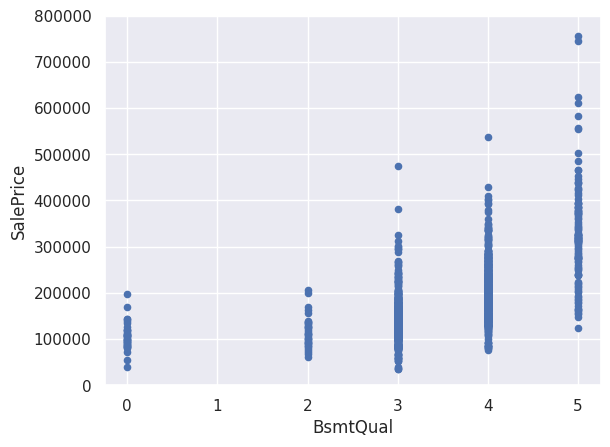

In [839]:
var = 'BsmtQual'
data = pd.concat([df['SalePrice'], df[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [840]:
df.dtypes

MSSubClass        int64
MSZoning         object
LotArea           int64
Street           object
LotShape         object
                  ...  
MoSold            int64
YrSold            int64
SaleType         object
SaleCondition    object
SalePrice         int64
Length: 66, dtype: object

In [841]:
df = pd.get_dummies(df)




In [842]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score
import numpy as np

# Log-transform SalePrice
df['SalePrice'] = np.log(df['SalePrice'])
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

# Model & CV setup
model = LinearRegression()
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation (log RMSE)
cv_scores_log = cross_val_score(
    model,
    X_train,
    y_train,
    cv=kfold,
    scoring='neg_root_mean_squared_error'
)
cv_rmse_scores_log = -cv_scores_log
print(f"CV Log-RMSE Scores: {cv_rmse_scores_log}")
print(f"Mean CV Log-RMSE: {np.mean(cv_rmse_scores_log):.4f} (±{np.std(cv_rmse_scores_log):.4f})")

# Fit model and evaluate on test set
model.fit(X_train, y_train)
test_pred_log = model.predict(X_test)

# Convert back to original scale
y_test_actual = np.exp(y_test)
test_pred_actual = np.exp(test_pred_log)

# RMSE in dollar terms
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_pred_actual))
print(f"\nTest Set RMSE (in $): ${test_rmse:,.2f}")

# Baseline prediction (mean of train log prices → back to original scale)
baseline_pred = np.exp([y_train.mean()] * len(y_test))
baseline_rmse = np.sqrt(mean_squared_error(y_test_actual, baseline_pred))
print(f"Baseline RMSE (mean predictor): ${baseline_rmse:,.2f}")


CV Log-RMSE Scores: [0.12831145 0.11121813 0.16315826 0.25250017 0.13015545]
Mean CV Log-RMSE: 0.1571 (±0.0506)

Test Set RMSE (in $): $22,421.46
Baseline RMSE (mean predictor): $74,887.34


In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_train, y_pred)  # Mean Squared Error (MSE)
rmse = np.sqrt(mse)                       # Take square root to get RMSE
print(f"RMSE: {rmse:.4f}")

RMSE: 20668.1027
